In [3]:
library(tidyverse)

**Data Specification**

In [4]:
## CoV Issued Building Permits
bperm_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/issued-building-permits/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
bperm_df <- read_delim(bperm_url, delim = ";") |>
        separate(col = geo_point_2d,
                 into = c("lat", "long"),
                 sep = ",")

Rows: 36509 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (15): PermitNumber, TypeOfWork, Address, ProjectDescription, PermitCate...
dbl   (3): PermitElapsedDays, ProjectValue, IssueYear
date  (2): PermitNumberCreatedDate, IssueDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)   

Rows: 100165 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
## 2023 CoV Property Tax Report Dataset
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"

ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   TAX_LEVY
                  )

Rows: 220567 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_df_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",")

In [8]:
head(ptax_df_merged)

LEGAL_TYPE,LAND_COORDINATE,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,lat,long
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
STRATA,77019103,496282,240000,1996,1996,2047.38,49.26333024794667,-123.09938095630145
STRATA,59623596,553000,49800,1977,1977,1676.20,49.27822295440411,-123.07086779777211
STRATA,59225072,280000,40800,1981,1981,892.04,49.28000735957126,-123.06899069724635
STRATA,59711728,610000,277000,1995,1995,2466.49,49.28823994952549,-123.12534105465522
STRATA,57917821,933000,356000,1997,1997,3584.32,49.283706409518146,-123.10369848504855
STRATA,59011894,285000,76800,1999,2000,3372.27,49.28795342891571,-123.12082069797775


**Geographic Distibutions of Data**

Warning message:
“Removed 156 rows containing missing values (geom_point).”


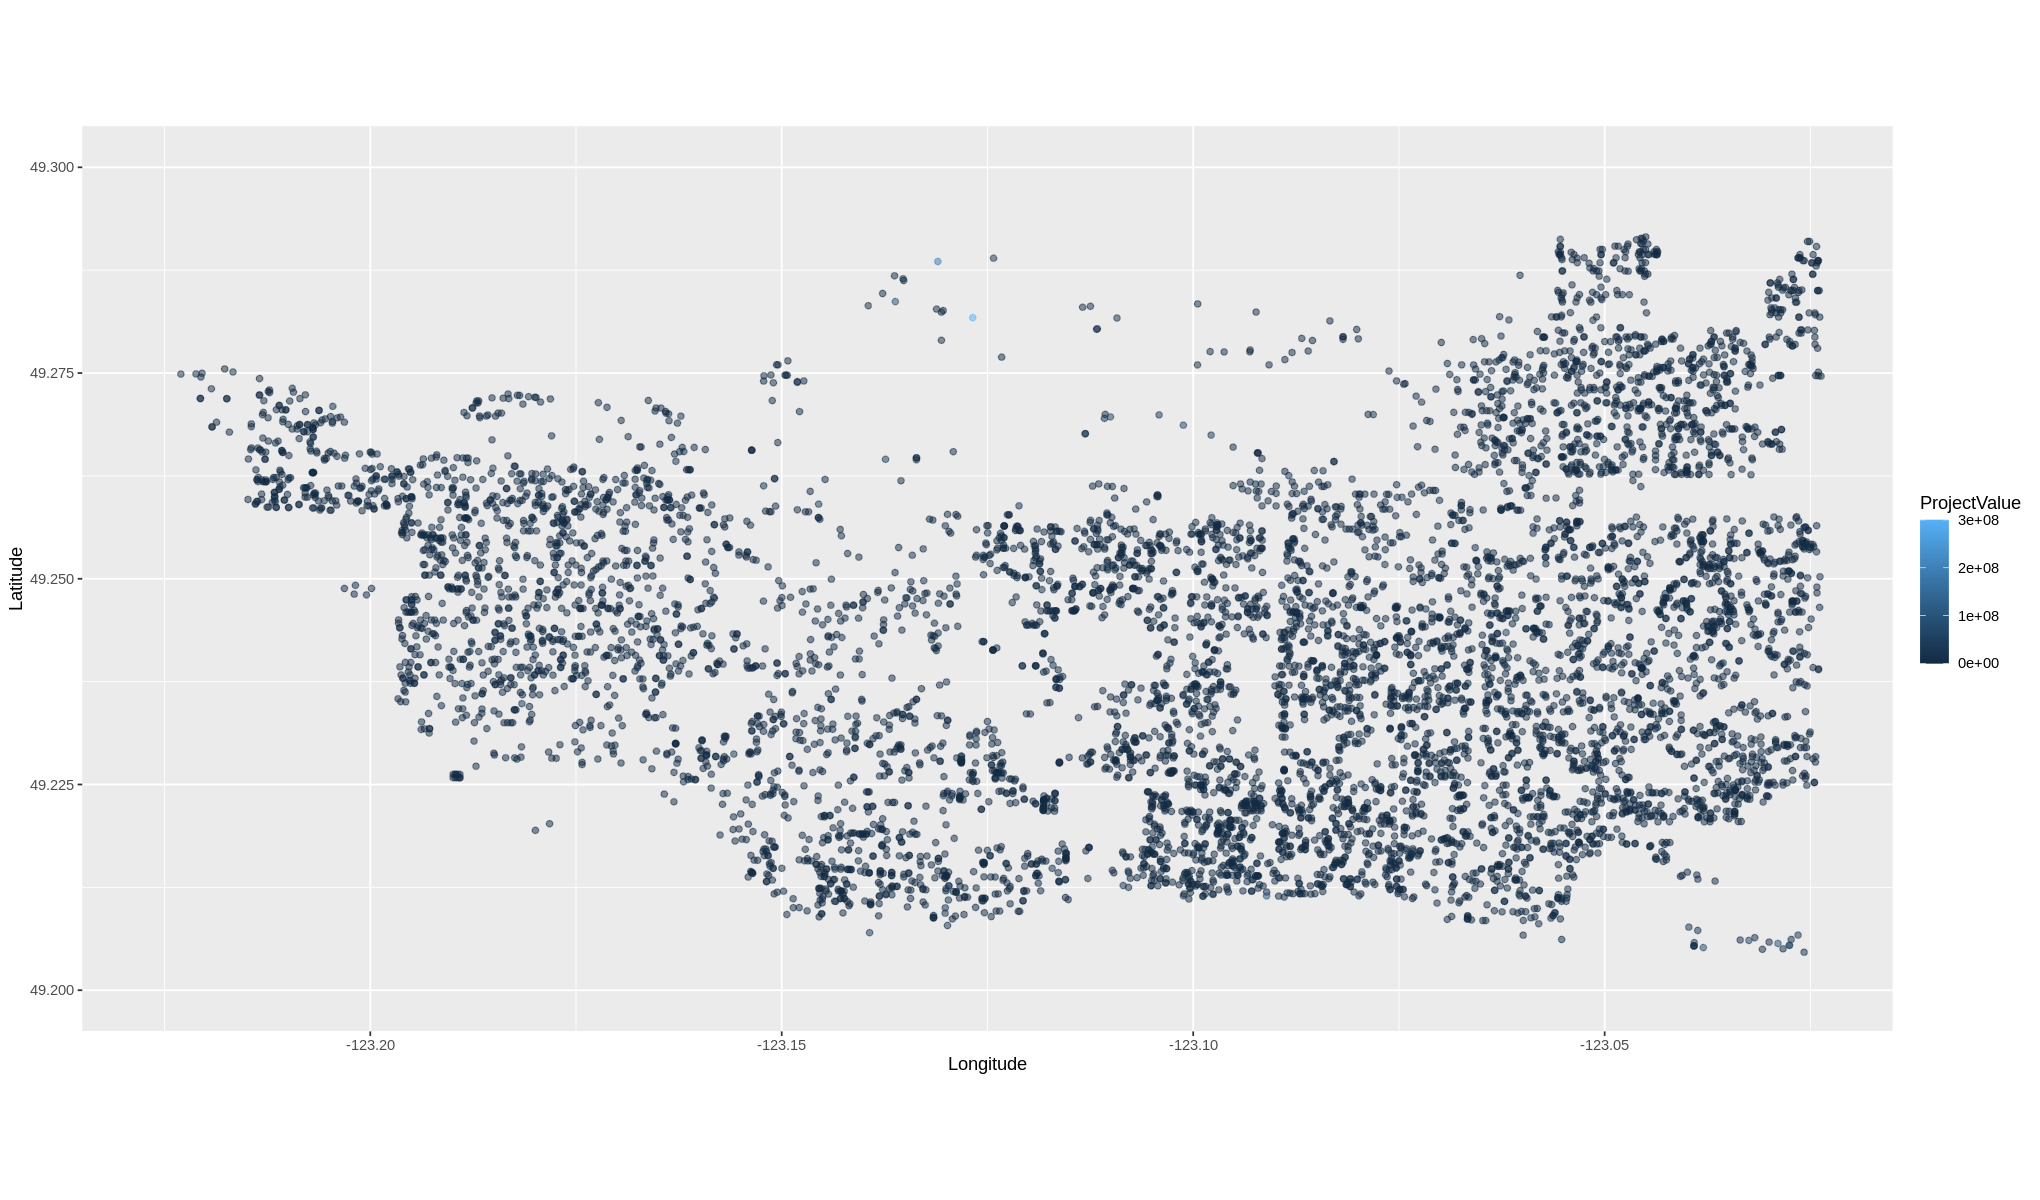

In [9]:
options(repr.plot.width = 17, repr.plot.height =10)
## Building Permits Plot
bperm_plot <- bperm_df |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                mutate(ProjectValue = as.double(ProjectValue)) |>
                filter(TypeOfWork == "New Building") |>
                filter(PropertyUse == "Dwelling Uses") |>
                ggplot(aes(x=long,y=lat,color=ProjectValue)) +
                geom_point(alpha = 0.5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", title = )
                
bperm_plot

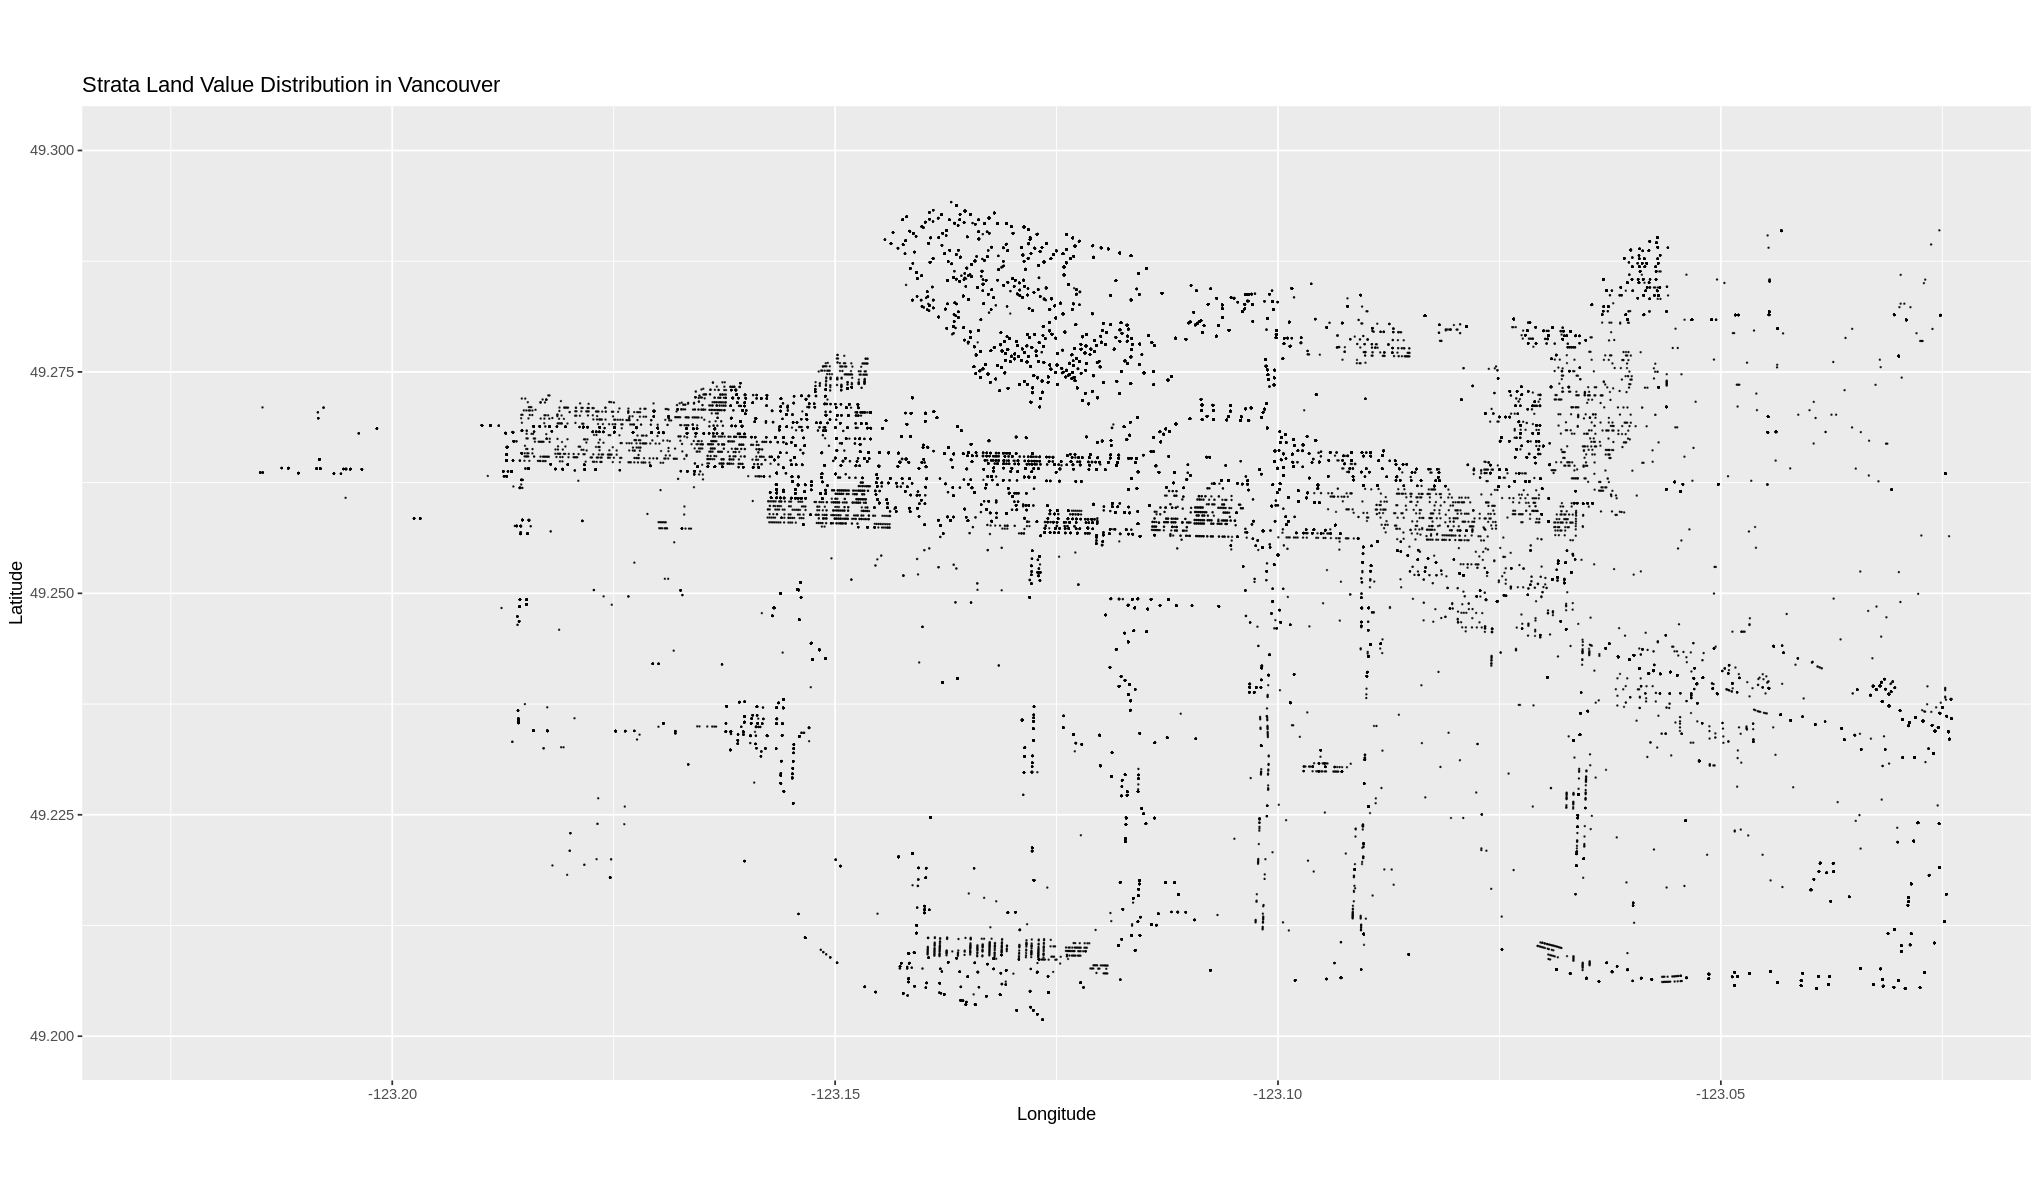

In [10]:
## Property Tax Plot
options(repr.plot.width = 17, repr.plot.height =10)
ptax_plot <- ptax_df_merged |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=long,y=lat)) +
                geom_point(alpha = 0.5, size = 0.025) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", color = "Current Land Value", title = "Strata Land Value Distribution in Vancouver")
ptax_plot

Warning message:
“Removed 1414 rows containing missing values (geom_point).”


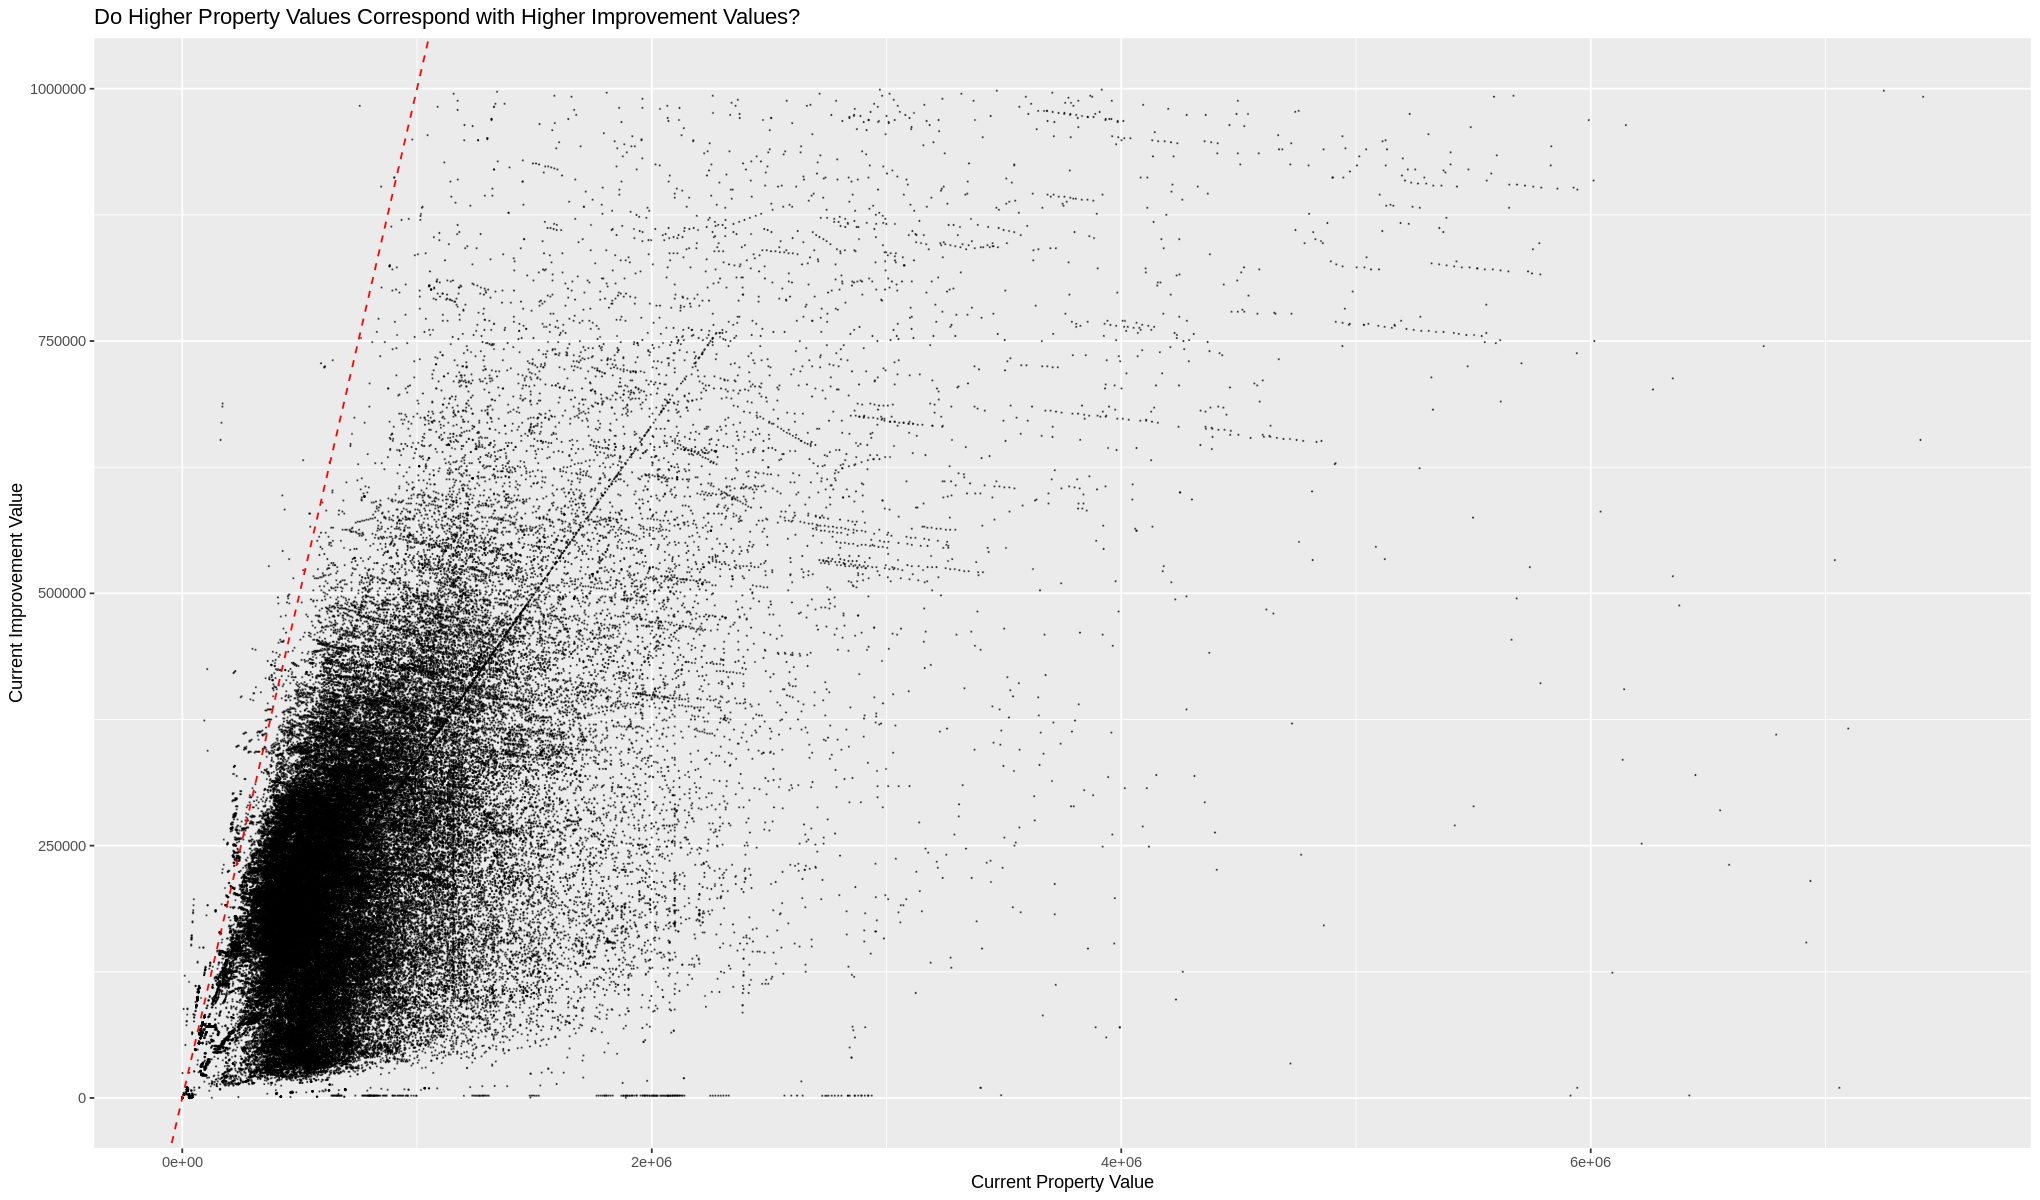

In [11]:
## Property Tax Plot
options(repr.plot.width = 17, repr.plot.height =10)
pval_vs_impv <- ptax_df_merged |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=CURRENT_LAND_VALUE,y=CURRENT_IMPROVEMENT_VALUE)) +
                geom_point(alpha = 0.5, size = 0.025) +
                xlim(0, 7.5*10^6) +
                ylim(0, 10^6) +
                geom_abline(intercept = 0, slope = 1, color="red", linetype="dashed", size=0.5)+
                labs(x = "Current Property Value", y = "Current Improvement Value", color = "Current Land Value", title = "Do Higher Property Values Correspond with Higher Improvement Values?")
pval_vs_impv